In [1]:
import sys

# import seaborn as sns
import numpy as np
from scipy import stats, integrate
import os
import matplotlib as mpl
import matplotlib.ticker as tk
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import re
from copy import deepcopy
from astropy.io import fits
from matplotlib.backends.backend_pdf import PdfPages
import datetime
import pandas as pd
import scipy.interpolate as interpolate
import json
import time
from astropy.time import Time
from tqdm import tqdm_notebook as tqdm

plt.rcParams.update({'font.size': 12})
sys.path.append('/home/jtb34/GitHub/GACF/')
#sys.path.append('/home/jtb34/python27')
# print sys.path
from NGTS.NGTS_Field import return_field_from_object_directory, NGTSField
from NGTS.GACF_utils import TIME_CONVERSIONS
import NGTS.GACF_utils as utils

ROOT_DIR = '/home/jtb34/rds/rds-jtb34-gacf/GACF_OUTPUTS'



/home/jtb34/GitHub/GACF/NGTS/NGTS_Field.py:11: UserWarning: ngtsio not imported
  warnings.warn("ngtsio not imported")
/home/jtb34/GitHub/GACF/NGTS/GACF_utils/ngtsio_utils.py:10: UserWarning: ngtsio not imported
  warnings.warn("ngtsio not imported")


In [2]:
XMATCH_LOCATION = '/home/jtb34/rds/rds-jtb34-gacf/GACF_OUTPUTS/{}/cross_match/'
XMATCH_FILE_NAME = 'Uncut_Final_{}.fits'
def load_gaia_params(fieldname, keys=['Gaia_Teff', 'Gaia_Radius', 'Gaia_BPmag','Gaia_RPmag',
                                      'Gaia_Gmag']):
    xmatch_path = os.path.join(XMATCH_LOCATION.format(fieldname),
                               XMATCH_FILE_NAME.format(fieldname))
    if not os.path.exists(xmatch_path):
#         print xmatch_path, 'does not exist'
        return None

    df = pd.DataFrame()
    with fits.open(xmatch_path) as gfits:
#         print gfits[1].header
        df['Obj_id'] = map(int, gfits[1].data['Sequence_number'].byteswap().newbyteorder())
        df['Gaia_Source_ID'] = map(int, gfits[1].data['Gaia_Source_ID'].byteswap().newbyteorder())
        for key in keys:
            df[key] = gfits[1].data[key].byteswap().newbyteorder()
    df['Field'] = fieldname
    if 'Gaia_BPmag' in keys and 'Gaia_RPmag' in keys:
        df['BPminusRP'] = df['Gaia_BPmag'] - df['Gaia_RPmag']
        
    return df

In [3]:
pdics = {}
fieldnames = []
field_pattern = re.compile(r'^NG\d+[+|-]\d+$')

for f in os.listdir(ROOT_DIR):
    if re.match(field_pattern, f):
        fieldnames.append(f)
print "Found {} fields".format(len(fieldnames))
# print fieldnames
# fieldnames = fieldnames[1:5]
# fieldnames = ['NG2346-3633']

for field in fieldnames:
    field_dir = os.path.join(ROOT_DIR, field)
    pdic_filename = 'NGTS_Field_{}_pdic.json'.format(field)
    if pdic_filename in os.listdir(field_dir):
        with open(os.path.join(*[ROOT_DIR, field, pdic_filename])) as f:
            pdics[field] = json.load(f)
            pdics[field] = {int(k):v for k,v in pdics[field].iteritems()}
            

# fieldnames = pdics.keys()
# fieldnames = ['NG0004-2950']
# with open('/home/jtb34/rds/hpc-work/GACF_OUTPUTS/NG0535-0523/NGTS_Field_NG0535-0523_pdic.json', 'r') as f:
#     pdic = json.load(f)

# pdic = {int(k):v for k,v in pdic.iteritems()}


object_pattern = re.compile(r'^(?P<obj>\d+)_VERSION_CYCLE1807$')
obj_lists = {}
for field in fieldnames:
    obj_list = []
    for f in os.listdir(os.path.join(ROOT_DIR, field)):
        match = re.match(object_pattern, f)
        if match is not None:
            obj_list.append(int(match.group('obj')))
    obj_lists[field] = np.array(obj_list)
# print 'Found {} objects'.format(len(obj_list))
# print pdic

# half_moon_objs = [(k, v[0]) for k,v in pdic.iteritems() if 13<v[0]<15]
# print half_moon_objs

Found 115 fields


In [4]:
# load all gaia data
dft = None
dft = pd.DataFrame()
for fieldname in tqdm(fieldnames, desc='Loading Xmatch Data From Fits'):
    df = load_gaia_params(fieldname)
    if df is not None:
        dft = dft.append(df)
# print len(dft)
dft.drop_duplicates(inplace=True, subset='Gaia_Source_ID', keep=False)
# print len(dft)
dft.set_index('Gaia_Source_ID', inplace=True)
dft.head()

SEJveChjaGlsZHJlbj0oSW50UHJvZ3Jlc3ModmFsdWU9MCwgZGVzY3JpcHRpb249dSdMb2FkaW5nIFhtYXRjaCBEYXRhIEZyb20gRml0cycsIG1heD0xMTUsIHN0eWxlPVByb2dyZXNzU3R5bGXigKY=


,Obj_id,Gaia_Teff,Gaia_Radius,Gaia_BPmag,Gaia_RPmag,Gaia_Gmag,Field,BPminusRP
Gaia_Source_ID,,,,,,,,
6836156100510577408,131,5286.90,NaN,13.2340,12.2867,13.0178,NG2126-1652,0.9473
6836333328041277184,132,3452.00,NaN,16.0108,13.5064,14.6567,NG2126-1652,2.5044
6841354522767460608,134,5357.41,1.47,14.8565,13.9116,14.4670,NG2126-1652,0.9449
6836333980876305792,150,6276.50,1.16,11.5984,10.9090,11.3270,NG2126-1652,0.6894
6842107241555682816,163,4359.00,0.66,16.0246,14.5239,15.3256,NG2126-1652,1.5007


In [5]:
# gaia_seq_nums = [g[1] for g in xmatch_ids if g[1] > 0]
# print len(gaia_seq_nums)
# print gaia_seq_nums

def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in xrange(0, len(l), n):
        yield l[i:i + n]

from astroquery.utils.tap.core import TapPlus
from astroquery.gaia import Gaia
# gaia = TapPlus(url="http://gea.esac.esa.int/tap-server/tap")
gaia_ids = dft.index
print 'Processing {} Gaia Ids'.format(len(gaia_ids))
max_rows = 5000
gaia_ids = [e for e in chunks(gaia_ids, max_rows)]
# gaia_ids = ', '.join(map(str, gaia_ids))
# print ', '.join(map(str, gaia_ids[:5]))
results = []
for gids in tqdm(gaia_ids, desc='Querying Gaia Archive', total=len(gaia_ids)):
    job_str =  "SELECT source_id, dist.r_est, dist.r_lo, dist.r_hi, dist.r_len, \
                dist.result_flag, dist.modality_flag \n \
                FROM external.gaiadr2_geometric_distance as dist \n \
                JOIN gaiadr2.gaia_source AS src USING (source_id) \n \
                WHERE source_id IN ({})".format(', '.join(map(str, gids)))
    # print job_str
    job = Gaia.launch_job_async(job_str)
    results.append(job.get_results())
# print r
distance_dics = [{k:v for k,v in zip(map(int, r['source_id'].tolist()), r['r_est'].tolist())} for r in results]
distances =  {k: v for d in distance_dics for k, v in d.items()}
df_distance = pd.DataFrame().from_dict(distances, orient='index', columns=['Distance'])
dft = dft.join(df_distance)
dft['AbsMag'] = dft['Gaia_Gmag'] - 5 * np.log10(dft['Distance']) + 5
dft.head()

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443
Processing 412789 Gaia Ids


SEJveChjaGlsZHJlbj0oSW50UHJvZ3Jlc3ModmFsdWU9MCwgZGVzY3JpcHRpb249dSdRdWVyeWluZyBHYWlhIEFyY2hpdmUnLCBtYXg9ODMsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGVzY3JpcHTigKY=


Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query finished.
Query fi

,Obj_id,Gaia_Teff,Gaia_Radius,Gaia_BPmag,Gaia_RPmag,Gaia_Gmag,Field,BPminusRP,Distance,AbsMag
Gaia_Source_ID,,,,,,,,,,
6836156100510577408,131,5286.90,NaN,13.2340,12.2867,13.0178,NG2126-1652,0.9473,388.894443,5.068641
6836333328041277184,132,3452.00,NaN,16.0108,13.5064,14.6567,NG2126-1652,2.5044,90.678945,9.869168
6841354522767460608,134,5357.41,1.47,14.8565,13.9116,14.4670,NG2126-1652,0.9449,1089.614683,4.280635
6836333980876305792,150,6276.50,1.16,11.5984,10.9090,11.3270,NG2126-1652,0.6894,293.503939,3.988930
6842107241555682816,163,4359.00,0.66,16.0246,14.5239,15.3256,NG2126-1652,1.5007,431.575358,7.150317


In [6]:
# Get rotation data from pdic
dft['GACF_Period'] = np.nan
for i, row in tqdm(dft.iterrows(), desc='Getting GACF Periods', total=len(dft)):
    try:
        dft.at[i, 'GACF_Period'] = pdics[row['Field']][row['Obj_id']][0]
    except KeyError:
        continue

SEJveChjaGlsZHJlbj0oSW50UHJvZ3Jlc3ModmFsdWU9MCwgZGVzY3JpcHRpb249dSdHZXR0aW5nIEdBQ0YgUGVyaW9kcycsIG1heD00MTI3ODksIHN0eWxlPVByb2dyZXNzU3R5bGUoZGVzY3LigKY=


In [7]:
# # Get GACF Periods (slow)
# dft['GACF_Period'] = None
# for fieldkey, fieldvalue in tqdm(pdics.iteritems(), desc='Getting GACF Periods', total=len(pdics)):
#     for objkey, objvalue in tqdm(fieldvalue.iteritems(), desc='Getting GACF Periods', total=len(fieldvalue)):
#         dft[(dft.Field == fieldkey) & (dft.Obj_id == objkey)]['GACF_Period'] = objvalue[0]

In [8]:
dft.head()

,Obj_id,Gaia_Teff,Gaia_Radius,Gaia_BPmag,Gaia_RPmag,Gaia_Gmag,Field,BPminusRP,Distance,AbsMag,GACF_Period
Gaia_Source_ID,,,,,,,,,,,
6836156100510577408,131,5286.90,NaN,13.2340,12.2867,13.0178,NG2126-1652,0.9473,388.894443,5.068641,NaN
6836333328041277184,132,3452.00,NaN,16.0108,13.5064,14.6567,NG2126-1652,2.5044,90.678945,9.869168,NaN
6841354522767460608,134,5357.41,1.47,14.8565,13.9116,14.4670,NG2126-1652,0.9449,1089.614683,4.280635,NaN
6836333980876305792,150,6276.50,1.16,11.5984,10.9090,11.3270,NG2126-1652,0.6894,293.503939,3.988930,NaN
6842107241555682816,163,4359.00,0.66,16.0246,14.5239,15.3256,NG2126-1652,1.5007,431.575358,7.150317,NaN


In [51]:
field_groups = dft.groupby(by=['Field']).count()
field_groups['Pct_retrieval'] = (field_groups['GACF_Period'] / field_groups['Obj_id']) * 100.
print field_groups['GACF_Period'].sum()
field_groups

5288


,Obj_id,Gaia_Teff,Gaia_Radius,Gaia_BPmag,Gaia_RPmag,Gaia_Gmag,BPminusRP,Distance,AbsMag,GACF_Period,radius_cut,teff_cut,Pct_retrieval
Field,,,,,,,,,,,,,
NG0004-2950,3374,3285,2622,3357,3357,3374,3357,3255,3255,115,2622,3285,3.408417
NG0304-1115,3175,3112,2421,3155,3154,3175,3154,3069,3069,57,2421,3112,1.795276
NG0313-2230,3381,3303,2784,3352,3352,3381,3352,3287,3287,0,2784,3303,0.000000
NG0348-3345,3783,3751,3326,3774,3774,3783,3774,3709,3709,51,3326,3751,1.348136
NG0353-3056,3932,3870,3430,3916,3916,3932,3916,3852,3852,56,3430,3870,1.424212
NG0409-1941,4286,4254,3596,4275,4275,4286,4275,4222,4222,68,3596,4254,1.586561
NG0445-3056,5118,5060,4556,5103,5103,5118,5103,5028,5028,55,4556,5060,1.074639
NG0448-3922,5152,5098,4532,5126,5126,5152,5126,5056,5056,68,4532,5098,1.319876
NG0450-3633,5177,5130,4606,5162,5162,5177,5162,5095,5095,57,4606,5130,1.101024


In [10]:
dft[(np.isfinite(dft['GACF_Period'])) & (dft['Field'] == 'NG0004-2950')]

,Obj_id,Gaia_Teff,Gaia_Radius,Gaia_BPmag,Gaia_RPmag,Gaia_Gmag,Field,BPminusRP,Distance,AbsMag,GACF_Period
Gaia_Source_ID,,,,,,,,,,,
2333292733614314496,84,5030.01,0.850000,15.5979,14.4870,15.1146,NG0004-2950,1.1109,734.662893,5.784159,31.568
2321422436144254464,626,5533.47,0.790000,12.6441,11.7073,12.2484,NG0004-2950,0.9368,234.577504,5.396968,5.375
2333096436428744192,1221,5783.00,1.050000,11.8177,11.0305,11.4911,NG0004-2950,0.7872,241.300990,4.578304,3.021
2333061733093062784,1283,5484.00,0.900000,12.4444,11.5415,12.0673,NG0004-2950,0.9029,238.425435,5.180537,4.965
2321382170826792320,1418,7570.67,1.160000,13.4710,13.0198,13.3057,NG0004-2950,0.4512,1025.046107,3.251983,7.186
2321041150423574016,2034,4852.58,0.690000,14.7101,13.3528,14.0858,NG0004-2950,1.3573,343.042891,6.409058,20.766
2333002737422104576,2260,4357.00,NaN,14.7791,13.2182,14.0402,NG0004-2950,1.5609,7033.830834,-0.195760,21.250
2321361623703278464,2953,4363.00,0.540000,12.7633,11.1489,11.9905,NG0004-2950,1.6144,76.206871,7.580529,21.333
2321340286305727872,3156,4976.00,0.570000,13.9975,12.6382,13.3788,NG0004-2950,1.3593,218.036458,6.686154,7.628


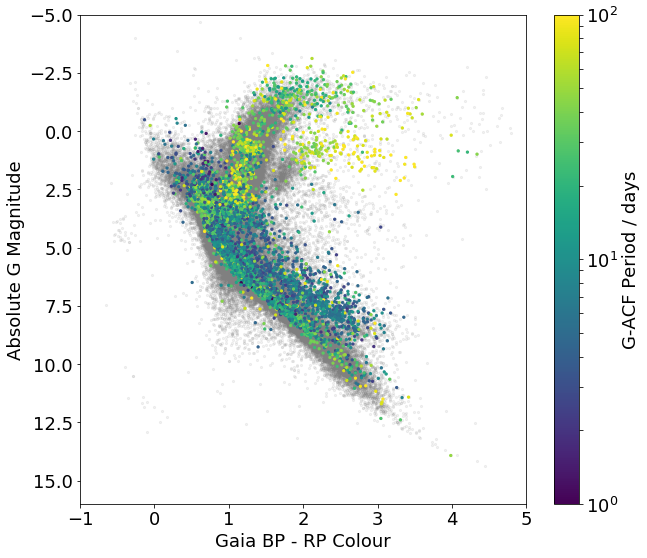

In [21]:

plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(figsize=(10,9))
ax.scatter(dft['BPminusRP'], dft['AbsMag'], c='gray', alpha=0.1, s=5)
scat = ax.scatter(dft['BPminusRP'], dft['AbsMag'], c=dft['GACF_Period'], cmap='viridis', 
                  norm=mpl.colors.LogNorm(vmin=1,vmax=100), s=5)
ax.set_xlim([-1.0, 5])
ax.set_ylim(16, -5)
# for fieldname in fieldnames:
#     plt.scatter(dft[dft['Field'] == fieldname]['BPminusRP'], dft[dft['Field'] == fieldname]['GACF_Period'], s=1,
#                label=fieldname)
cb=fig.colorbar(scat, ax=ax)

ax.set_xlabel('Gaia BP - RP Colour')
ax.set_ylabel('Absolute G Magnitude')
cb.set_label('G-ACF Period / days')

plt.savefig('HR_Diagram_Jul19.png')

plt.show()


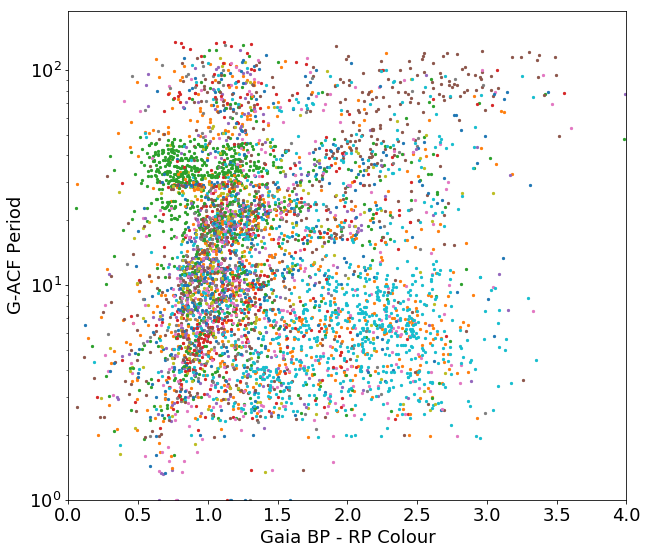

In [45]:

plt.rcParams.update({'font.size': 18})
color = mpl.cm.rainbow(np.linspace(0,1,42)) # This returns RGBA; convert:
hexcolor = map(lambda rgb:'#%02x%02x%02x' % (rgb[0]*255,rgb[1]*255,rgb[2]*255),
               tuple(color[:,0:-1]))


fig, ax = plt.subplots(figsize=(10,9))
i = 0 
for fieldname in fieldnames:
    dfp = dft[dft['Field'] == fieldname]
    if np.any(np.isfinite(dfp['GACF_Period'])):
        ax.scatter(dfp['BPminusRP'], dfp['GACF_Period'], s=5, label=fieldname)
        i += 1
ax.set_xlim([0, 4])
# ax.set_ylim(16, -5)
ax.set_yscale('log')
# for fieldname in fieldnames:
#     plt.scatter(dft[dft['Field'] == fieldname]['BPminusRP'], dft[dft['Field'] == fieldname]['GACF_Period'], s=1,
#                label=fieldname)

ax.set_ylim(bottom=1)

ax.set_xlabel('Gaia BP - RP Colour')
ax.set_ylabel('G-ACF Period')
# ax.legend( markerscale=2., scatterpoints=1)

plt.savefig('BPminusRPJul19.png')

plt.show()



In [37]:
i

41

In [29]:
np.any(np.isfinite(dft['GACF_Period']))

True

In [12]:
radius_cuts = [0, 1, 3, float("inf")]
teff_cuts = [0, 5000, 6000, float("inf")]

dft['radius_cut'] = pd.cut(dft['Gaia_Radius'], radius_cuts)
dft['teff_cut'] = pd.cut(dft['Gaia_Teff'], teff_cuts)
# dft.groupby(['radius_cut', 'teff_cut']).size()
pd.pivot_table(dft, aggfunc='count', index=['radius_cut','teff_cut'], values=['Obj_id', 'GACF_Period'])

GACF_Period  Obj_id
radius_cut teff_cut                             
(0.0, 1.0] (0.0, 5000.0]            1250   66141
           (5000.0, 6000.0]          715   68210
           (6000.0, inf]              11    3540
(1.0, 3.0] (0.0, 5000.0]             648   11919
           (5000.0, 6000.0]          745  122161
           (6000.0, inf]             293   36517
(3.0, inf] (0.0, 5000.0]             456   20950
           (5000.0, 6000.0]          148    6288
           (6000.0, inf]              23     437

In [167]:
dft.to_csv('all_gacf_data.csv')

In [180]:
dft['GACF_Period'].count()

2763

In [179]:
dft['teff_cut'].unique()

[(5000.0, 6000.0], (0.0, 5000.0], (6000.0, inf], NaN]
Categories (3, interval[float64]): [(0.0, 5000.0] < (5000.0, 6000.0] < (6000.0, inf]]